In [21]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from matplotlib.pyplot import hist
# import more functions or modules if you need them !!

In [37]:
# set random seed for numpy
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [22]:
oil_df = pd.read_pickle('../Data/data/comprehensive_new.pkl')

In [23]:
oil_df

,onset2COWCS,onsetUCS,coup,periregular,numcode,year,ecgrowth,logmountain,ethnic_fractionalization,religion_fractionalization,...,valoilres_binarize,valoilres_public_diff,valoilres_public_binarize,oilpop_diff,oilpop_binarize,valoilres_impute_diff,valoilres_impute_binarize,oilpop_impute_diff,oilpop_impute_binarize,milexp_pergdpSIPRI_diff
0,0.00001,NaN,NaN,NaN,4,1929.0,NaN,0.041836,0.007693,0.002717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00001,NaN,NaN,0.00001,4,1930.0,NaN,0.041836,0.007693,0.002717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00001,NaN,NaN,0.00001,4,1931.0,NaN,0.041836,0.007693,0.002717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00001,NaN,NaN,0.00001,4,1932.0,NaN,0.041836,0.007693,0.002717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00001,NaN,NaN,0.00001,4,1933.0,NaN,0.041836,0.007693,0.002717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17915,0.00001,0.00001,0.00001,NaN,894,2004.0,0.038210,-0.016094,0.007808,0.007359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
17916,0.00001,0.00001,0.00001,NaN,894,2005.0,0.038433,-0.016094,0.007808,0.007359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
17917,NaN,0.00001,0.00001,NaN,894,2006.0,0.045788,-0.016094,0.007808,0.007359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
17918,NaN,0.00001,0.00001,NaN,894,2007.0,0.045470,-0.016094,0.007808,0.007359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [24]:
# ATT and ATE AIPTW
def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
    """
    Double ML estimator for the ATT
    This uses the ATT specific scores, see equation 3.9 of https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf
    Return: aiptw of ATE and its standard error
    """
    
    # number of observations
    n = Y.shape[0]
    
    # estimate marginal probability of treatment
    if prob_t is None:
        prob_t = A.mean() 
    
    # att aiptw
    tau_hat = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0)).mean()/ prob_t
  
    # influence curve and standard error of aiptw
    phi = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0) - tau_hat*A) / prob_t
    std_hat = np.std(phi) / np.sqrt(n)

    return tau_hat, std_hat

def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
    """
    Double ML estimator for the ATE
    Return: aiptw of ATE and its standard error
    """
    # number of observations
    n = Y.shape[0]
    
    # ate aiptw
    tau_hat = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g)).mean()
  
    # influence curve and standard error of aiptw
    phi = Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g) - tau_hat   
    std_hat = np.std(phi) / np.sqrt(n)

    return tau_hat, std_hat

In [84]:
# Conditional outcome models (Q models)
def make_linear_Q_model():
    ''' A function that returns a linear q model for later use in k-folding'''
    return LinearRegression()

def make_Q_model(output_type:str):
    ''' A function that returns a general ML q model for later use in k-folding'''
    if output_type == 'binary':
        return RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)
    return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)
# One example: RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)

In [85]:
# Propensity score models (g models)
def make_g_model():
    ''' A function that returns a g model for computing propensity scores'''
    return RandomForestClassifier(n_estimators=100, max_depth=5)
# One example: RandomForestClassifier(n_estimators=100, max_depth=5)

In [86]:
# Functions for K-fold cross-fitting
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    '''
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    '''

    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
        X_train = X.loc[train_index]
        A_train = A.loc[train_index]
        g = make_model()
        g.fit(X_train, A_train)

        # get predictions for split
        predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]
    
    # sanity check that overlap holds
    assert np.isnan(predictions).sum() == 0
    return predictions

def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"
    '''

    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model(output_type)
        q.fit(X_train, y_train)

        if output_type =='binary':
            predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
            predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
        elif output_type == 'continuous':
            predictions0[test_index] = q.predict(X0.loc[test_index])
            predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [87]:
model_vars = ['onset2COWCS',
              'valoilres_binarize',
              'ecgrowth',
              'pop_maddison_diff',
              'popdens_diff',
              'democracy_diff',
              'logmountain',
              'ethnic_fractionalization',
              'religion_fractionalization',
              'language_fractionalization',
              'leg_british',
              'numcode',
              'year']

In [88]:
all_vars = ['popdens_diff',
            'milexp_pergdpSIPRI_diff',
            'pop_maddison_diff', 
            'democracy_diff',
            'wildcat_diff',
            'out_regdisaster_diff',
            'valoilres_diff',
            'valoilres_public_diff',
            'oilpop_diff',
            'valoilres_impute_diff',
            'oilpop_impute_diff',
            'onset2COWCS',
            'onsetUCS',
            'coup',
            'periregular',
            'numcode',
            'year',
            'ecgrowth',
            'logmountain',
            'ethnic_fractionalization',
            'religion_fractionalization',
            'language_fractionalization',
            'leg_british',
            'no_transition']

In [89]:
model_1_df = oil_df[model_vars].dropna().reset_index()

In [90]:
model_1_df = model_1_df.replace({'onset2COWCS': .00001}, 0)

In [91]:
model_1_df

,index,onset2COWCS,valoilres_binarize,ecgrowth,pop_maddison_diff,popdens_diff,democracy_diff,logmountain,ethnic_fractionalization,religion_fractionalization,language_fractionalization,leg_british,numcode,year
0,195,0.0,0.0,0.021566,0.030159,0.000297,0.000000,0.027537,0.003394,0.000091,0.004427,0.00001,12,1964.0
1,196,0.0,0.0,0.035326,0.030159,0.000297,-0.500000,0.027537,0.003394,0.000091,0.004427,0.00001,12,1965.0
2,197,0.0,0.0,-0.077295,0.031434,0.000310,0.000000,0.027537,0.003394,0.000091,0.004427,0.00001,12,1966.0
3,198,0.0,0.0,0.057393,0.034148,0.000336,0.000000,0.027537,0.003394,0.000091,0.004427,0.00001,12,1967.0
4,199,0.0,0.0,0.084017,0.030231,0.000298,0.000000,0.027537,0.003394,0.000091,0.004427,0.00001,12,1968.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5169,17912,0.0,0.0,0.025446,0.022981,0.000227,0.363636,-0.016094,0.007808,0.007359,0.008734,0.01000,894,2001.0
5170,17913,0.0,0.0,0.014076,0.018515,0.000184,0.000000,-0.016094,0.007808,0.007359,0.008734,0.01000,894,2002.0
5171,17914,0.0,0.0,0.034933,0.015692,0.000156,0.000000,-0.016094,0.007808,0.007359,0.008734,0.01000,894,2003.0
5172,17915,0.0,0.0,0.038210,0.015008,0.000149,0.000000,-0.016094,0.007808,0.007359,0.008734,0.01000,894,2004.0


In [92]:
outcome = model_1_df['onset2COWCS']
treatment = model_1_df['valoilres_binarize']
confounders = model_1_df[[x for x in model_vars if x not in ['onset2COWCS', 'valoilres_binarize']]]

In [93]:
g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=5)

(array([ 267., 1208., 1434., 1094.,  633.,  308.,  153.,   55.,   19.,
           3.]),
 array([0.02077116, 0.05830565, 0.09584015, 0.13337464, 0.17090913,
        0.20844363, 0.24597812, 0.28351261, 0.3210471 , 0.3585816 ,
        0.39611609]),
 <BarContainer object of 10 artists>)

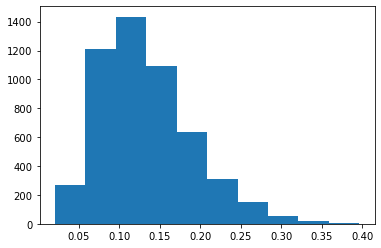

In [94]:
hist(g)

In [95]:
g[g < .04]

array([0.03613051, 0.03820147, 0.0361128 , 0.03974227, 0.03594024,
       0.03594024, 0.03594024, 0.03982512, 0.03904212, 0.03392243,
       0.03703389, 0.03979947, 0.03738883, 0.03482985, 0.0367949 ,
       0.03062839, 0.0363243 , 0.03316555, 0.03886627, 0.02751622,
       0.0227076 , 0.02077116, 0.03630402, 0.03834326, 0.03628344,
       0.03603796, 0.03216008, 0.03900635, 0.03307875, 0.03674085,
       0.02858015, 0.03535011, 0.02281893, 0.03358999, 0.02749258,
       0.03955865])

In [96]:
# get conditional outcomes
Q0_ml, Q1_ml = outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, \
                                              n_splits=5, output_type="binary")

In [97]:
data_and_nuisance_estimates_ml = pd.DataFrame({'g': g, 'Q0': Q0_ml, 'Q1': Q1_ml, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_ml

,g,Q0,Q1,A,Y
0,0.162224,0.000,0.0064,0.0,0.0
1,0.135921,0.246,0.2380,0.0,0.0
2,0.164924,0.028,0.0300,0.0,0.0
3,0.110240,0.002,0.0120,0.0,0.0
4,0.135433,0.000,0.0064,0.0,0.0
...,...,...,...,...,...
5169,0.114169,0.002,0.0040,0.0,0.0
5170,0.077983,0.008,0.0100,0.0,0.0
5171,0.076430,0.004,0.0100,0.0,0.0
5172,0.097327,0.006,0.0100,0.0,0.0


In [98]:
# ate aiptw
tau_hat, std_hat = ate_aiptw(**data_and_nuisance_estimates_ml)
print(f"The ATE AIPTW is {tau_hat} with a std = {std_hat}")

The ATE AIPTW is 0.0037062453899312465 with a std = 0.004348622650063888
